## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd
import networkx as nx

es = Elasticsearch(['atlas-kibana-2.mwt2.org:9200'],timeout=60)
my_index = "network_weather_2-*"

my_query = {}

##  Select your link

In [2]:
sS='UC'
srcSiteOWDServer = "192.170.227.160"
srcSiteThroughputServer = "192.170.227.162"

# sS='IU'
# srcSiteOWDServer = "149.165.225.223"
# srcSiteThroughputServer = "149.165.225.224"

dS='UIUC'
destSiteOWDServer = "72.36.96.4"
destSiteThroughputServer = "72.36.96.9"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query':{
        'filtered':{
            'query': { "match_all": {} },
            'filter':{
                'bool':{
                    'must':[
                        {'range': {'timestamp': {'gte': '2016-08-19', 'lt': '2016-08-21'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                {'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteOWDServer}},
                                {'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                {'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteOWDServer}},
                                {'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
            }
        }
    }
}

scroll = list(scan(client=es, query=my_query))


In [23]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
edges[sS]={}
edges[dS]={}
for res in scroll:
    count += 1
    dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S')
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'latency':
        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    elif column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    elif column_type == 'throughput':
        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
    elif column_type == 'traceroute':
        data[s].set_value( ts, 'hash', res['_source']['hash'])
        ho=res['_source']['hops']
        cn=res['_source']['src'] # first device is not in list of hops
        for n in ho: # adding nodes
            if cn not in edges[s]: edges[s][cn]={}
            if n not in edges[s][cn]: 
                edges[s][cn][n]=1
            else:
                edges[s][cn][n]+=1
            cn=n
        #print(edges)
    if count<2: print(res, ts)
print(count)

{'_type': 'traceroute', '_id': 'AVahpviqd25u_mmDbDAx', '_index': 'network_weather_2-2016.8.19', '_source': {'src': '192.170.227.162', 'timestamp': '2016-08-19T07:04:09', 'srcVO': 'ATLAS', 'hash': 6761207925750194111, 'dest': '72.36.96.9', 'srcSite': 'MWT2', 'MA': '192.170.227.162', 'destSite': 'MWT2', 'srcProduction': False, 'hops': ['192.170.226.1', '192.170.224.77', '192.170.224.98', '72.36.80.13', '130.126.1.110', '72.36.96.9'], 'destProduction': False, 'destVO': 'ATLAS'}, '_score': 0.0} 1471590249000.0
4841


### saving in pickle files

In [24]:
a=data[sS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
a.to_pickle("Data/FullOneLinkData" + '_' + sS + '-' + dS + ".pkl")

a=data[dS]
print (a.count(axis='index'))
a.sort_index(inplace=True)    # Sort the records based on time
a.to_pickle("Data/FullOneLinkData" + '_' + dS + '-' + sS + ".pkl")

timestamp       1079
hash             481
delay_median     576
delay_mean       576
delay_sd         576
packet_loss      576
throughput        23
dtype: int64
timestamp       1041
hash             445
delay_median     576
delay_mean       576
delay_sd         576
packet_loss      576
throughput        21
dtype: int64


### Select a pair of source - destination

In [39]:
F = data[sS]
B = data[dS]
Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
Fd = F[F.delay_mean<4]
Bd = B[B.delay_mean<4]

Fh = F[F.hash.notnull()]
Bh = B[B.hash.notnull()]
Fu, Fids = np.unique(Fh.hash, return_inverse=True)
Bu, Bids = np.unique(Bh.hash, return_inverse=True)


In [40]:
# Fthr

In [41]:
print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])
print(edges)

throughput  forward:  23  backward:  21
packet loss forward:  576  backward:  576
delay       forward:  576  backward:  574
hash        forward:  481  backward:  445
{'UIUC': {'72.36.80.14': {'192.170.224.97': 447}, '192.170.224.97': {'192.170.224.78': 432, '192.170.227.162': 15}, '192.170.224.78': {'192.170.227.162': 432}, '72.36.96.9': {'72.36.96.1': 447}, '130.126.1.109': {'72.36.80.14': 447}, '72.36.96.1': {'130.126.1.109': 447}}, '72.36.96.9': {'72.36.96.1': 447}, '192.170.227.162': {'192.170.224.77': 25, '192.170.226.1': 457}, '192.170.224.98': {'72.36.80.13': 482}, 'UC': {'192.170.224.77': {'192.170.224.98': 482}, '192.170.226.1': {'192.170.224.77': 457}, '192.170.227.162': {'192.170.224.77': 25, '192.170.226.1': 457}, '72.36.80.13': {'130.126.1.110': 482}, '130.126.1.110': {'72.36.96.9': 482}, '192.170.224.98': {'72.36.80.13': 482}}, '72.36.80.14': {'192.170.224.97': 447}, '192.170.224.77': {'192.170.224.98': 482}, '192.170.224.97': {'192.170.224.78': 432, '192.170.227.162': 15

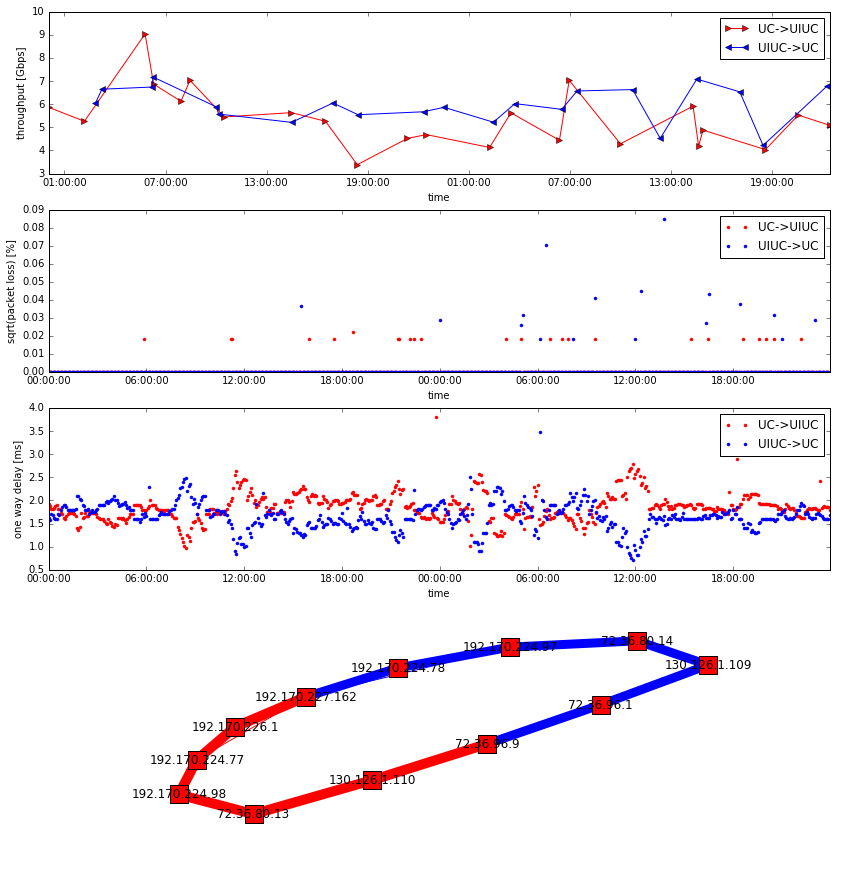

In [44]:
plt.figure(figsize=[14, 15])
gs = gridspec.GridSpec(4, 1, height_ratios=[2,2,2,3])

ax0 = plt.subplot(gs[0])
ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
ax0.set_xlabel('time')
ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#plt.xlim(xmin=0)
ax0.legend()

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()


ax4 = plt.subplot(gs[2])
ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax4.set_xlabel('time')
ax4.set_ylabel('one way delay [ms]')
ax4.legend()


ax5 = plt.subplot(gs[3])
G=nx.Graph()
for p in edges[sS]:
    for s in edges[sS][p]:
        G.add_edge(p,s,color='r',weight=edges[sS][p][s])
for p in edges[dS]:
    for s in edges[dS][p]:
        G.add_edge(p,s,color='b',weight=edges[dS][p][s])
        
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos,node_size=200)
# nx.draw_networkx_edges(G,pos)

dedges = G.edges()
colors = [G[u][v]['color'] for u,v in dedges]
weights = [math.ceil(G[u][v]['weight']/50) for u,v in dedges]

nx.draw(G, pos, edges=dedges, edge_color=colors,node_shape='s', width=weights,with_labels=True)
# nx.draw_networkx_labels(G,pos,font_size=15,font_family='sans-serif')

plt.axis('off')
plt.savefig('Plots/AllPlotForLinkSimple_' + sS +'_'+ dS + '.png')
plt.show()